In [ ]:
# Import necessary libraries
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error # type: ignore
import numpy as np # type: ignore

## 1. Load Stock Market Data
The dataset contains stock prices from different indices. We'll first load and explore the data.

In [2]:
# Load the datasets
index_data = pd.read_csv("data/indexData.csv")
index_data.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [3]:
index_info = pd.read_csv("data/indexInfo.csv")
index_info.head()

,Region,Exchange,Index,Currency
0,United States,New York Stock Exchange,NYA,USD
1,United States,NASDAQ,IXIC,USD
2,Hong Kong,Hong Kong Stock Exchange,HSI,HKD
3,China,Shanghai Stock Exchange,000001.SS,CNY
4,Japan,Tokyo Stock Exchange,N225,JPY


## 2. Exploratory Data Analysis (EDA)
Before building models, let's visualize stock trends and understand data patterns.

In [4]:
# Convert 'Date' column to datetime format
index_data["Date"] = pd.to_datetime(index_data["Date"])
index_data = index_data.sort_values("Date")  # Sort by Date
index_data["Date"].head()

92450   1965-01-05
92451   1965-01-06
92452   1965-01-07
92453   1965-01-08
92454   1965-01-11
Name: Date, dtype: datetime64[ns]

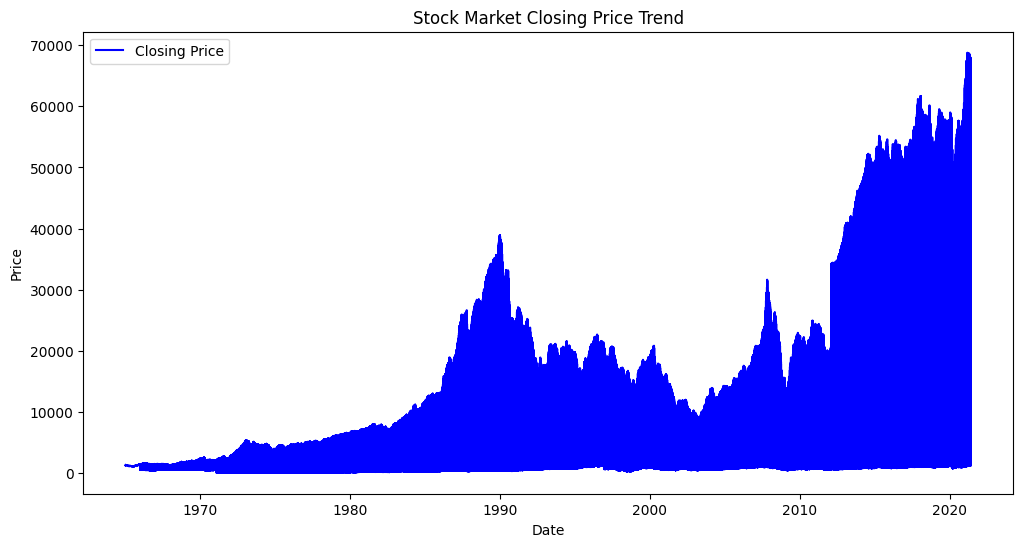

In [5]:
# Plot Closing Price Trend
plt.figure(figsize=(12, 6))
plt.plot(index_data["Date"], index_data["Close"], label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Market Closing Price Trend")
plt.legend()
plt.show()

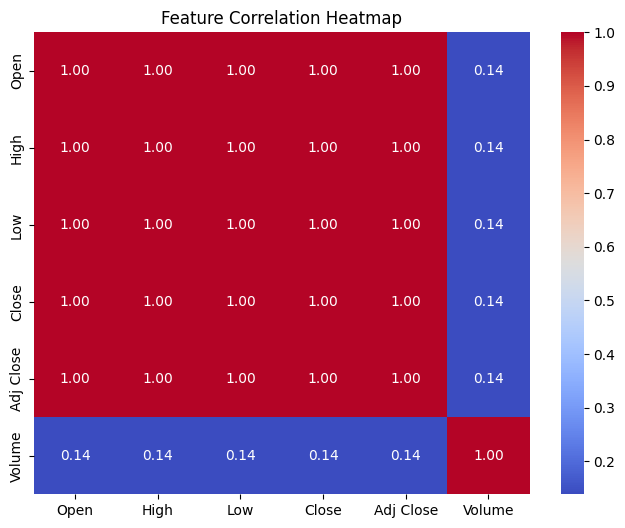

In [ ]:
# Select only numeric columns for correlation analysis
numeric_data = index_data.select_dtypes(include=['number'])

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
# Check for missing values
print("--------Index Data-------------")
print(index_data.isnull().sum())
print("--------Index Info-------------")
print(index_info.isnull().sum())

--------Index Data-------------
Index           0
Date            0
Open         2204
High         2204
Low          2204
Close        2204
Adj Close    2204
Volume       2204
dtype: int64
--------Index Info-------------
Region      0
Exchange    0
Index       0
Currency    0
dtype: int64


In [ ]:
# Handle missing values by forward-filling
# Forward-filling (ffill) is a method used to handle missing values by filling them with the most recent previous value in the dataset.
index_data.fillna(method="ffill", inplace=True)


# Verify changes
print("Updated missing values:")
print(index_data.isnull().sum())

Updated missing values:
Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_11128\36127031.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  index_data.fillna(method="ffill", inplace=True)


In [ ]:
# Merge indexData with indexInfo to add region and currency information
merged_data = index_data.merge(index_info, on="Index", how="left")
merged_data

,Index,Date,Open,High,Low,Close,Adj Close,Volume,Region,Exchange,Currency
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,United States,New York Stock Exchange,USD
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,United States,New York Stock Exchange,USD
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,United States,New York Stock Exchange,USD
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,United States,New York Stock Exchange,USD
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,United States,New York Stock Exchange,USD
...,...,...,...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0,Europe,Euronext,EUR
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0,Europe,Euronext,EUR
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0,Europe,Euronext,EUR
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0,Europe,Euronext,EUR


## 3. Model Training
We'll use Linear Regression to predict future stock prices. This model assumes a linear relationship between past prices and future prices.

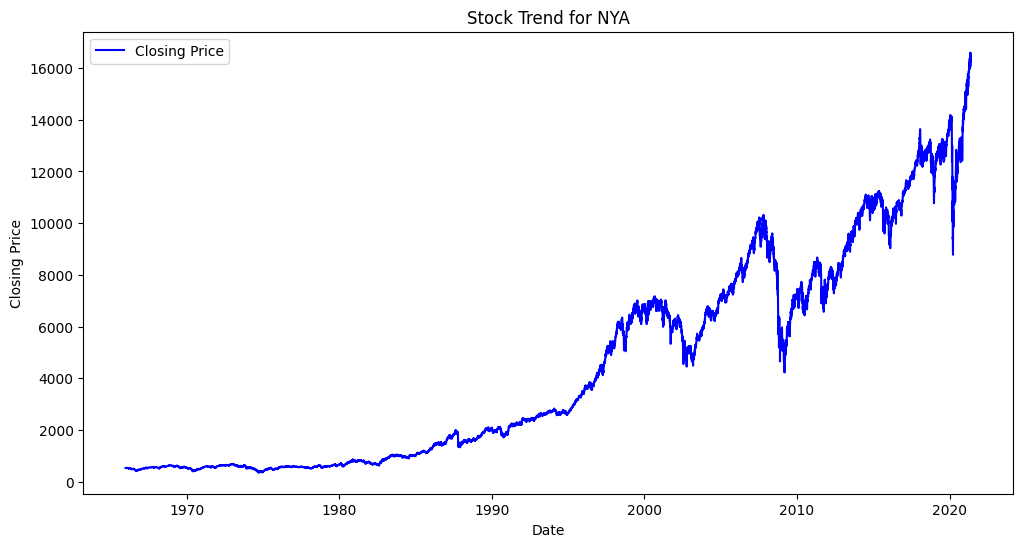

In [ ]:
# Plot stock trends for a specific index (e.g., NYA)
def plot_stock_trends(index_name):
    df = merged_data[merged_data["Index"] == index_name]
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date"], df["Close"], label="Closing Price", color="blue")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"Stock Trend for {index_name}")
    plt.legend()
    plt.show()

# Example: Visualizing stock trends for NYA
plot_stock_trends("NYA")

## 4. Model Evaluation
The model's performance is evaluated using **Mean Absolute Error (MAE)** and **Mean Squared Error (MSE)**. Lower values indicate better predictions.

Model Performance for NYA:
Mean Absolute Error: 3045.537924838797
Mean Squared Error: 12017391.883755298
Root Mean Squared Error: 3466.611008428159


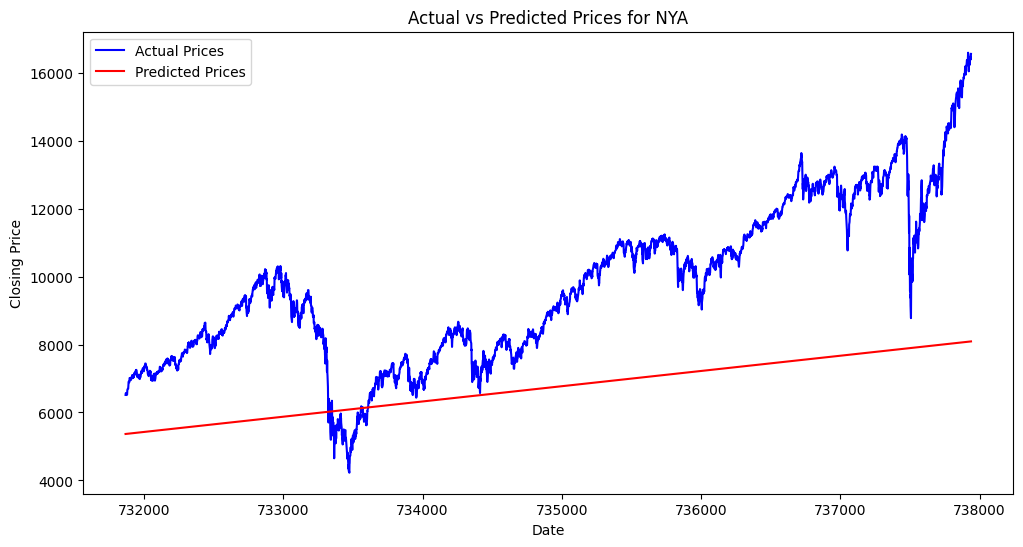

In [ ]:
# Machine Learning Model - Predicting Future Stock Prices
def train_stock_model(index_name):
    df = merged_data[merged_data["Index"] == index_name].copy()
    df["Date"] = df["Date"].map(pd.Timestamp.toordinal)  # Convert date to numerical format
    
    # Features and target variable
    X = df[["Date"]]
    y = df["Close"]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    print(f"Model Performance for {index_name}:")
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

    # Plot actual vs predicted closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df["Date"].iloc[-len(y_test):], y_test, label="Actual Prices", color="blue")
    plt.plot(df["Date"].iloc[-len(y_pred):], y_pred, label="Predicted Prices", color="red")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.title(f"Actual vs Predicted Prices for {index_name}")
    plt.legend()
    plt.show()

# Example: Train and evaluate model for NYA
train_stock_model("NYA")


## 5. Business Insights & Recommendations
- The stock prices show trends influenced by external factors like economic events.
- The Linear Regression model provides a rough estimate but may not capture sudden market shifts.
- To improve predictions, consider using **time-series models** like LSTMs or incorporating **economic indicators**.